In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent, TFT
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
import random




In [140]:
def random_walk(n,level=30):
    tot = np.zeros(n)
    probs = np.zeros(n)
    for i in range(n-1):
        prob = random.random()
        if prob<0.5:
            delta = 1
        else:
            delta = -1
        tot[i+1] = tot[i] + delta
        probs[i+1]= prob +(random.random()/level-0.5/level)
    return tot, probs

In [141]:
N = 20000
random.seed(330)
x, p = random_walk(N)
data = pd.DataFrame({'y':x/x.max(),'p':p,'time':range(N)})

In [142]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
ts.load_signal(data,enrich_cat=[],target_variables=['y'],past_variables= [],future_variables=['p'])
ts.set_verbose(True)
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 1
future_steps = 64

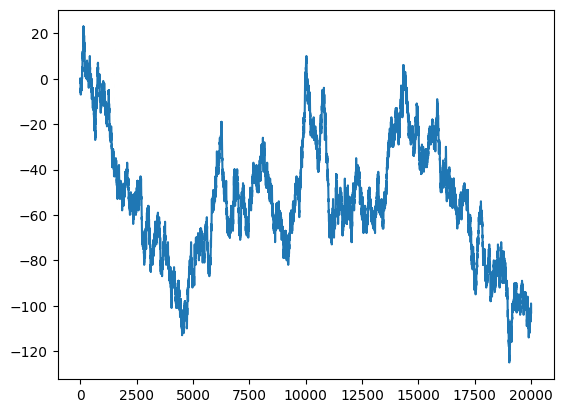

In [143]:
plt.plot(x)

In [144]:
split_params = {'perc_train':0.6,'perc_valid':0.2,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'shift':0,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [169]:
res_tot = {}
for w in np.arange(0,300,50):
    print(w)
    config = dict(model_configs =dict(
                                        past_steps = past_steps,
                                        future_steps = future_steps,
                                        past_channels = len(ts.past_variables),
                                        future_channels = len(ts.future_variables),
                                        embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                        cat_emb_dim = 8,
                                        kernel_size = 15,
                                         use_bn = False,
                                        dropout_rate=0.0,
                                          optim='torch.optim.Adam',
                                          activation= 'torch.nn.GELU',
                                         sum_emb = True,
                                         out_channels = len(ts.target_variables),
                                        hidden_size = 2048,
                                        kind='nlinear',
                                        quantiles= [],
                                        persistence_weight =w,
                                        simple=False,loss_type='exponential_penalization'
                                        ),
                    scheduler_config = dict(gamma=0.1,step_size=24000000000000000),
                    optim_config = dict(lr = 0.0005,weight_decay=0.00))
    model_linear = LinearTS(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'],verbose=True )
    ts.set_model(model_linear,config=config,custom_init=False )
    #train the model for 50 epochs with auto_lr_find 
    ts.train_model(dirpath=f"/home/agobbi/Projects/ExpTS/rf/linear",
                   split_params=split_params,
                   batch_size=64,
                   num_workers=2,
                   max_epochs=20,
                   auto_lr_find=True)
    res = ts.inference_on_set(200,4,set='test',rescaling=True)
    res_tot[w] = res.copy()

0


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: You

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 84 steps due to diverging loss.
Learning rate set to 0.000630957344480193
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_92c10b57-15c4-427a-ae7e-b8b2e0f2a79f.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_92c10b57-15c4-427a-ae7e-b8b2e0f2a79f.ckpt

  | Name   | Type       | Params
--------------------------------------
0 | embs   | ModuleList | 0     
1 | loss   | L1Loss     | 0     
2 | linear | ModuleList | 2.9 M 
--------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.624    Total estimated model params size (MB)
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Saving losses on file because multigpu not working
50


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: You

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 89 steps due to diverging loss.
Learning rate set to 9.120108393559096e-06
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_774e46b7-4ef6-4881-8fa6-3bb09a62964e.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_774e46b7-4ef6-4881-8fa6-3bb09a62964e.ckpt

  | Name   | Type       | Params
--------------------------------------
0 | embs   | ModuleList | 0     
1 | loss   | L1Loss     | 0     
2 | linear | ModuleList | 2.9 M 
--------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.624    Total estimated model params size (MB)
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Saving losses on file because multigpu not working
100


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: You

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.3981071705534969
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_30d1389c-8c2b-4284-bcdd-29643978c316.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_30d1389c-8c2b-4284-bcdd-29643978c316.ckpt

  | Name   | Type       | Params
--------------------------------------
0 | embs   | ModuleList | 0     
1 | loss   | L1Loss     | 0     
2 | linear | ModuleList | 2.9 M 
--------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.624    Total estimated model params size (MB)
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which 

Saving losses on file because multigpu not working
150


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: You

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.3981071705534969
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_49e63fd6-aa26-4d90-a47a-4af00929e7e1.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_49e63fd6-aa26-4d90-a47a-4af00929e7e1.ckpt

  | Name   | Type       | Params
--------------------------------------
0 | embs   | ModuleList | 0     
1 | loss   | L1Loss     | 0     
2 | linear | ModuleList | 2.9 M 
--------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.624    Total estimated model params size (MB)
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which 

Saving losses on file because multigpu not working
200


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: You

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 91 steps due to diverging loss.
Learning rate set to 9.120108393559096e-06
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_5425b5c4-2a9c-4f40-97f2-eec647ac30ed.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_5425b5c4-2a9c-4f40-97f2-eec647ac30ed.ckpt

  | Name   | Type       | Params
--------------------------------------
0 | embs   | ModuleList | 0     
1 | loss   | L1Loss     | 0     
2 | linear | ModuleList | 2.9 M 
--------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.624    Total estimated model params size (MB)
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Saving losses on file because multigpu not working
250


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: You

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 90 steps due to diverging loss.
Learning rate set to 9.120108393559096e-06
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_85983885-b8da-49ee-aa18-d1c918153e97.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/linear/.lr_find_85983885-b8da-49ee-aa18-d1c918153e97.ckpt

  | Name   | Type       | Params
--------------------------------------
0 | embs   | ModuleList | 0     
1 | loss   | L1Loss     | 0     
2 | linear | ModuleList | 2.9 M 
--------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.624    Total estimated model params size (MB)
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Saving losses on file because multigpu not working


<Axes: >

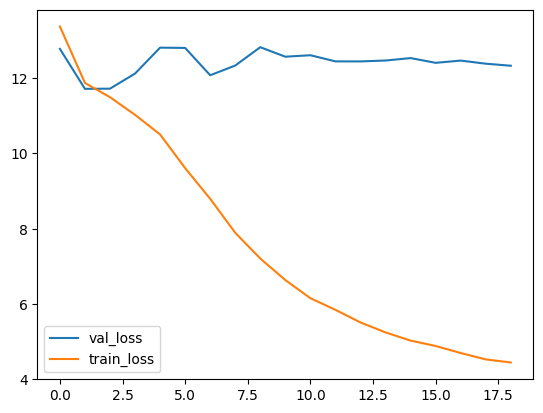

In [170]:
ts.losses.plot()



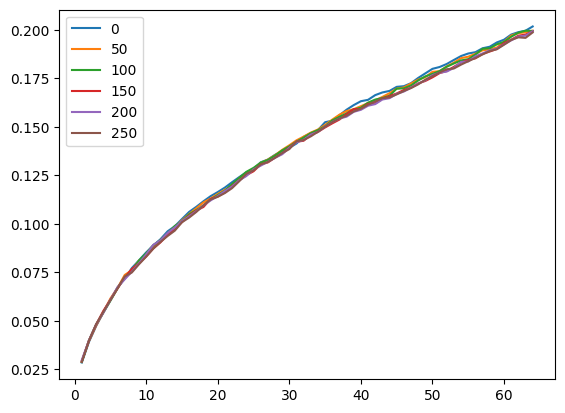

In [171]:
error = {}
for k in res_tot.keys():
    error[k] = res_tot[k].groupby('lag').apply(lambda x: np.sqrt(np.mean((x.y_pred-x.y)**2))).reset_index()
    plt.plot(error[k].lag, error[k][0],label=k)
plt.legend()

In [172]:
#0.5 --  0.026778758
#0   -- 0.027390912

In [173]:
##0 -- 0.026814144
##2 -- 0.026652765
##5 -- 0.026685152

In [174]:
res_tot[k]['prediction_time'] = res_tot[k].apply(lambda x: int(x.time-x.lag), axis=1)


In [175]:
res_tot[k]

,lag,time,y,y_pred,prediction_time
0,1,16001,-2.130435,-2.133335,16000
1,1,16002,-2.086957,-2.079328,16001
2,1,16003,-2.043478,-2.025806,16002
3,1,16004,-2.086957,-2.077057,16003
4,1,16005,-2.043478,-2.083466,16004
...,...,...,...,...,...
251835,64,19994,-4.347826,-4.209854,19930
251836,64,19995,-4.391304,-4.333173,19931
251837,64,19996,-4.434783,-4.289540,19932
251838,64,19997,-4.478261,-4.305706,19933


In [176]:
for i,k in enumerate(res_tot.keys()):
    res_tot[k]['prediction_time'] = res_tot[k].apply(lambda x: int(x.time-x.lag), axis=1)


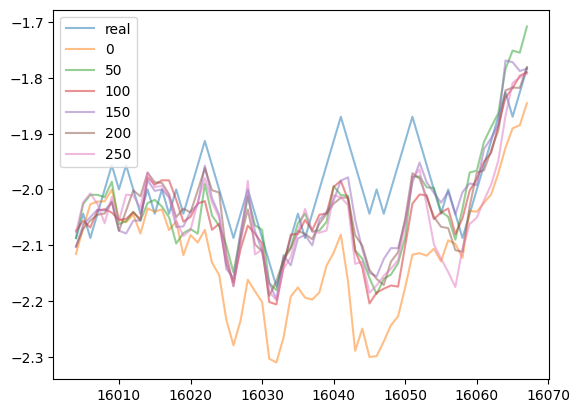

In [177]:
plt.figure()
date = 16003

for i,k in enumerate(res_tot.keys()):
    if i ==0:
        plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y,label='real',alpha=0.5)
    plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y_pred,label=k,alpha=0.5)
plt.legend()

In [159]:
for k in res_tot:
    print(k,res_tot[k].groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'}).error.mean())

0 0.021013822
3 0.020967174
6 0.020958338
9 0.020910274
12 0.020815838
15 0.020920306
18 0.021121733
21 0.021156292
24 0.02070712
27 0.020903014


In [154]:
for k in res_tot:
    print(k,res_tot[k].groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'}).error.mean())

0 0.021013822
3 0.020967174
6 0.020958338
9 0.020910274
12 0.020815838
15 0.020920306
18 0.021121733
21 0.021156292
24 0.02070712
27 0.020903014
